# Knapsack optimization problem: Oregon congressional apportionment 
### This is the first step in the algorithm: Obtain a starting point with equal populations.  The steps afterwards will include adding constraints to overcome any unwanted aspects of the solution.
Last Updated: 2020-01-05

In [1]:
# initializing useful modules, packages, or libraries
import geopandas as gpd # shapefile for Oregon county maps
import numpy as np  # data
import pandas as pd # data
# import shapefile as shp
from PIL import Image, ImageOps # images
# from IPython.display import Image # display images, import pillow for more functions
from plotnine import ggplot, aes, geom_map, geom_text, geom_label # plots
from plotnine import * # needed for theme
from pulp import * # for the optimization model with linear programming

### The Oregon congressional apportionment map from the 2010 census looks as follows. 
#### The 2010 population for these 5 districts had the following populations according to ballotopedia :
1st District - 775,806 - 2nd District - 770,403 - 3rd District - 782,486 - 4th District - 770,184 - 5th District - 772,980  
#### According to 2019 estimations, populations increased (https://www.census.gov/mycd/) : 
1st District - 858,875 - 2nd District - 841,022 - 3rd District - 853,116 - 4th District - 820,504 - 5th District - 844,220 

Here is the 2020 census apportionment.  More detail is available at census.gov.


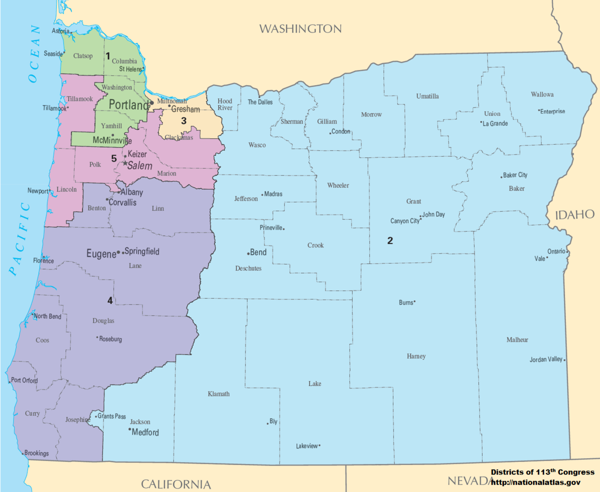

In [2]:
print('\033[1m'+'Here is the 2020 census apportionment.  More detail is available at census.gov.')
im_2010 = Image.open('Oregon_Congressional_Districts,_113th.png') 
resized_im_2010 = im_2010.resize((round(im_2010.size[0]*0.5), round(im_2010.size[1]*0.5)))
display(resized_im_2010)

### The increase in Oregon's population has outpaced the US average increase 
This means that if there remain five congressional districts, each congressperson would represent ~840,000 people.  However, due to the population increase and the graph below which shows Oregon was already close to gaining a 6th district in 2020, it is likely that Oregon will receive a 6th district, in which case each congressperson would represent ~700,000 people.


This infographic from the Pew Research Center shows that Oregon was close to receiving a 6th congressperson in 2010.


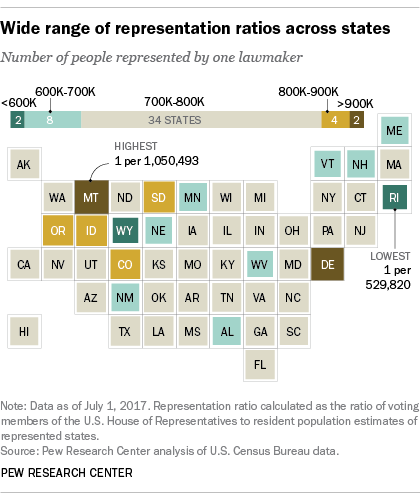

In [3]:
print('\033[1m'+'This infographic from the Pew Research Center shows that Oregon was close to receiving a 6th congressperson in 2010.')
im_pew = Image.open('FT_18.05.18_RepresentationRatios_states.png')
# im_with_border = ImageOps.expand(im_pew,border=3)
display(im_pew)

### Before the congressional apportionment model, let's review the state of Oregon population by county

In [4]:
county_id = list(range(0, 36)) 
county_names = list(['Baker','Benton','Clackamas','Clatsop','Columbia','Coos','Crook','Curry','Deschutes','Douglas','Gilliam','Grant','Harney','Hood River','Jackson','Jefferson','Josephine','Klamath','Lake','Lane','Lincoln','Linn','Malheur','Marion','Morrow','Multnomah','Polk','Sherman','Tillamook','Umatilla','Union','Wallowa','Wasco','Washington','Wheeler','Yamhill']) 
population_by_county = pd.DataFrame({'County_ID': [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35],
                                     'County_Name': ['Baker','Benton','Clackamas','Clatsop','Columbia','Coos','Crook','Curry','Deschutes','Douglas','Gilliam','Grant','Harney','Hood River','Jackson','Jefferson','Josephine','Klamath','Lake','Lane','Lincoln','Linn','Malheur','Marion','Morrow','Multnomah','Polk','Sherman','Tillamook','Umatilla','Union','Wallowa','Wasco','Washington','Wheeler','Yamhill'],
                                     'Population2018' : [16765,93590,419425,39200,51900,63275,22710,22915,188980,111735,1985,7400,7380,25310,219200,23560,86395,67960,8115,375120,48210,125575,31925,344035,11885,813300,82100,1785,26395,80765,26885,7175,27200,606280,1450,107415],
                                     'Population2010' : [16134,85579,375992,37039,49351,63043,20978,22364,157733,107667,1871,7445,7422,22346,203206,21720,82713,66380,7895,351715,46034,116672,31313,315335,11173,735334,75403,1765,25250,75889,25748,7008,25213,529710,1441,99193],
                                     'Change2010_2018': [631,8011,43433,2161,2549,232,1732,551,31247,4068,114,-45,-42,2964,15994,1840,3682,1580,220,23405,2176,8903,612,28700,712,77966,6697,20,1145,4876,1137,167,1987,76570,9,8222],
                                     'Latitude': [44.7346,44.4929,45.3088,46.1068,45.9189,43.175,44.1533,42.6002,43.9856,43.253,45.4204,44.5335,43.2214,45.6007,42.4441,44.4914,42.3351,42.5663,42.7821,44.0123,44.6733,44.4924,43.9454,44.9367,45.4757,45.5437,44.9262,45.4041,45.3957,45.726,45.3181,45.5356,45.3856,45.5404,44.7845,45.2256],
                                     'Longitude': [-117.6777,-123.3844,-122.3999,-123.8773,-122.9863,-124.179,-120.4523,-124.3343,-121.1699,-123.373,-120.2077,-119.0668,-119.0481,-121.7147,-122.7875,-121.3246,-123.5119,-121.6302,-120.4691,-123.1668,-123.9267,-122.7806,-117.484,-122.7301,-119.6694,-122.5346,-123.3237,-120.7307,-123.8622,-118.745,-117.9619,-117.2036,-121.2283,-123.002,-120.02,-123.1982]})
shapefile_oregon = gpd.read_file('orcounty.shp')
map_population_by_county_data = shapefile_oregon.merge(population_by_county, left_on='NAME', right_on='County_Name',suffixes=('_left', '_right'))
population_matrix = np.array(population_by_county['Population2018'])
state_population = sum(population_matrix)

The Willamette River valley contributes to ~70% of the state population.


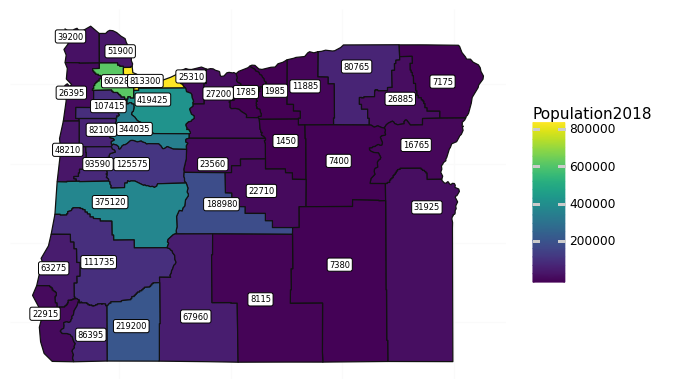

<ggplot: (8776789391815)>

In [5]:
map_population_by_county = (
ggplot(map_population_by_county_data)
+ geom_map(aes(fill='Population2018'))
+ geom_label(aes(x = 'Longitude', y = 'Latitude', label='Population2018',size=2), show_legend=False)
+ theme_minimal()
+ theme(axis_text_x=element_blank(),
        axis_text_y=element_blank(),
        axis_title_x=element_blank(),
        axis_title_y=element_blank(),
        axis_ticks=element_blank(),
        panel_grid_major = element_blank()
       )
)
print('\033[1m'+'The Willamette River valley contributes to ~70% of the state population.')
map_population_by_county

This map shows that population growth from 2010 to 2020 occurred in the most populous counties.


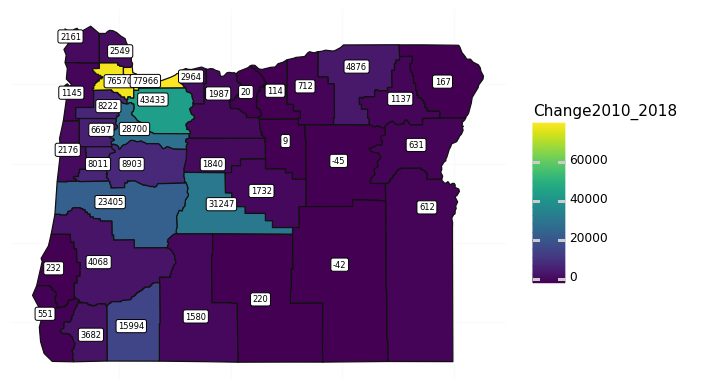

<ggplot: (8776789987578)>

In [6]:
print('\033[1m'+'This map shows that population growth from 2010 to 2020 occurred in the most populous counties.')
map_population_by_county = (
ggplot(map_population_by_county_data)
+ geom_map(aes(fill='Change2010_2018'))
+ geom_label(aes(x = 'Longitude', y = 'Latitude', label='Change2010_2018', size=2), show_legend=False)
+ theme_minimal()
+ theme(axis_text_x=element_blank(),
        axis_text_y=element_blank(),
        axis_title_x=element_blank(),
        axis_title_y=element_blank(),
        axis_ticks=element_blank(),
        panel_grid_major = element_blank()
       )
)
map_population_by_county

### The first step in this congressional apportionment modeling process, or algorithm, is to run the following optimization model.  After running the initial model, additional constraints will be added to hone in on the solution.

In [7]:
n_counties = 36
n_districts = 6
model = LpProblem("Supply-Demand-Problem", LpMinimize) # create model
variable_names = [str(i)+str(j) for j in range(1, n_districts+1) for i in range(1, n_counties+1)]
variable_names.sort() # print("Variable Indices:", variable_names)

# decision variables
# assignment is whether or not the county is assigned to the district
DV_variable_y = LpVariable.matrix("Y",variable_names,cat="Binary")
assignment = np.array(DV_variable_y).reshape(36,6)

# allocation is the amount of population from a county to a district
DV_variable_x = LpVariable.matrix("X",variable_names,cat="Integer",lowBound=0)#upBound N/A
allocation = np.array(DV_variable_x).reshape(36,6)

# This objective function minimizes the counties are split among multiple districts.
# In future model improvements, that objective will move to a constraint and the new 
#      objective will minimize the spread of the districts, increasing compactness.
objective_function = pulp.lpSum(assignment) 

In [8]:
# Assignment / Allocation Constraints

for i in range(n_counties):
    # allocate no more from each county than what the county has
    model += lpSum(allocation[i][j] for j in range(n_districts)) <= population_matrix[i] , "Allocation max " + str(i)
    # ensure all population from each county is allocated
    model += lpSum(allocation[i][j] for j in range(n_districts)) == lpSum(population_matrix[i]) , "Allocate All " + str(i)
        

for i in range(n_counties): 
    for j in range(n_districts):
        # allocation can only be greater than zero if assignment is greater than zero
        # 5999888 is a big M, which is larger than the Oregon total population
        model += allocation[i][j] <= 5999888*assignment[i][j] , "Allocation assignment " + str(i) + str(j)
        if assignment[i][j] == 1:
            # at least 20% of population must be allocated to each district for that county
            model += allocation[i][j] >= assignment[i][j]*0.20*population_matrix[i] , "Allocation min " + str(i) + str(j)

# Contiguous districts constraints
# e.g. Coos County (5) borders only Curry County (7) or Douglas County (8)
#      Therefore at least (7) or (8) need to be allocated to any district that has (5)
for j in range(n_districts):
    model += assignment[0][j] <= assignment[11][j]+assignment[22][j]+assignment[30][j]+assignment[31][j]  
    model += assignment[1][j] <= assignment[19][j]+assignment[20][j]+assignment[21][j]+assignment[26][j] 
    model += assignment[2][j] <= assignment[13][j]+assignment[23][j]+assignment[25][j]+assignment[32][j]+assignment[33][j]+assignment[35][j]
    model += assignment[3][j] <= assignment[4][j]+assignment[28][j] 
    model += assignment[4][j] <= assignment[3][j]+assignment[25][j]+assignment[33][j]
    model += assignment[5][j] <= assignment[7][j]+assignment[9][j] 
    model += assignment[6][j] <= assignment[8][j]+assignment[11][j]+assignment[12][j]+assignment[15][j]+assignment[34][j]
    model += assignment[7][j] <= assignment[5][j]+assignment[9][j]+assignment[16][j] 
    model += assignment[8][j] <= assignment[6][j]+assignment[12][j]+assignment[15][j]+assignment[17][j]+assignment[18][j]+assignment[19][j]+assignment[21][j]
    model += assignment[9][j] <= assignment[5][j]+assignment[7][j]+assignment[14][j]+assignment[16][j]+assignment[17][j]+assignment[19][j]
    model += assignment[10][j] <= assignment[24][j]+assignment[27][j]+assignment[32][j]+assignment[34][j]
    model += assignment[11][j] <= assignment[0][j]+assignment[6][j]+assignment[12][j]+assignment[22][j]+assignment[24][j]+assignment[29][j]+assignment[30][j]+assignment[34][j]
    model += assignment[12][j] <= assignment[6][j]+assignment[8][j]+assignment[11][j]+assignment[18][j]+assignment[22][j]
    model += assignment[13][j] <= assignment[2][j]+assignment[25][j]+assignment[32][j]
    model += assignment[14][j] <= assignment[9][j]+assignment[16][j]+assignment[17][j]
    model += assignment[15][j] <= assignment[6][j]+assignment[8][j]+assignment[21][j]+assignment[23][j]+assignment[32][j]+assignment[34][j]
    model += assignment[16][j] <= assignment[7][j]+assignment[9][j]+assignment[14][j]
    model += assignment[17][j] <= assignment[8][j]+assignment[9][j]+assignment[14][j]+assignment[18][j]+assignment[19][j]
    model += assignment[18][j] <= assignment[8][j]+assignment[12][j]+assignment[17][j]
    model += assignment[19][j] <= assignment[1][j]+assignment[8][j]+assignment[9][j]+assignment[17][j]+assignment[20][j]+assignment[21][j]
    model += assignment[20][j] <= assignment[1][j]+assignment[19][j]+assignment[26][j]+assignment[28][j]
    model += assignment[21][j] <= assignment[1][j]+assignment[8][j]+assignment[15][j]+assignment[19][j]+assignment[23][j]+assignment[26][j] 
    model += assignment[22][j] <= assignment[0][j]+assignment[11][j]+assignment[12][j]
    model += assignment[23][j] <= assignment[2][j]+assignment[15][j]+assignment[21][j]+assignment[26][j]+assignment[32][j]+assignment[35][j]
    model += assignment[24][j] <= assignment[10][j]+assignment[11][j]+assignment[29][j]+assignment[34][j]
    model += assignment[25][j] <= assignment[2][j]+assignment[4][j]+assignment[13][j]+assignment[33][j]
    model += assignment[26][j] <= assignment[1][j]+assignment[20][j]+assignment[21][j]+assignment[23][j]+assignment[28][j]+assignment[35][j]
    model += assignment[27][j] <= assignment[10][j]+assignment[32][j]
    model += assignment[28][j] <= assignment[3][j]+assignment[20][j]+assignment[26][j]+assignment[33][j]+assignment[35][j]
    model += assignment[29][j] <= assignment[11][j]+assignment[24][j]+assignment[30][j]+assignment[31][j]
    model += assignment[30][j] <= assignment[0][j]+assignment[11][j]+assignment[29][j]+assignment[31][j]
    model += assignment[31][j] <= assignment[0][j]+assignment[29][j]+assignment[30][j]
    model += assignment[32][j] <= assignment[2][j]+assignment[10][j]+assignment[13][j]+assignment[15][j]+assignment[23][j]+assignment[27][j]+assignment[34][j]
    model += assignment[33][j] <= assignment[2][j]+assignment[4][j]+assignment[25][j]+assignment[28][j]+assignment[35][j]
    model += assignment[34][j] <= assignment[6][j]+assignment[10][j]+assignment[11][j]+assignment[15][j]+assignment[24][j]+assignment[32][j]
    model += assignment[35][j] <= assignment[2][j]+assignment[23][j]+assignment[26][j]+assignment[28][j]+assignment[33][j]
    
# District size constraints, in order to keep the size of districts by population similar
for j in range(n_districts):
    model += lpSum(allocation[i][j] for i in range(n_counties)) <= 750000 , "District Size Maximum " + str(j)
    model += lpSum(allocation[i][j] for i in range(n_counties)) >= 650000 , "District Size Minimum " + str(j)

# Only allow counties that meet certain critera to be split among multiple districts
# A county must have population > 200,000 to be split among up to two districts
for i in range(n_counties):
    if population_matrix[i] <= 200000: 
        model += assignment[i][0]+assignment[i][1]+assignment[i][2]+assignment[i][3]+assignment[i][4]+assignment[i][5] <= 1 , "Unique Assignment " + str(i)
    else:
        model += assignment[i][0]+assignment[i][1]+assignment[i][2]+assignment[i][3]+assignment[i][4]+assignment[i][5] <= 2 , "Up-to-two Assignments " + str(i)

In [9]:
model.solve(PULP_CBC_CMD()) 
print('The model status is: ',LpStatus[model.status])
print('The objective value is: ', pulp.value(objective_function))

The model status is:  Optimal
The objective value is:  40.0


Since there are 36 counties, the unconstrainted lower bound for the objective function would be 36.  However, the value of 40 means that there are 4 times that a county was assigned to multiple districts.

In [10]:
# Which counties are assigned to each district, and total the populations
print('State Population: ', f"{state_population:,.0f}")
print('Assigned Population: ', f"{pulp.value(lpSum(allocation[i][j] for i in range(n_counties) for j in range(n_districts))):,.0f}", '\n')
def thousands(x):
    try:
        return '{:,}'.format(int(x))
    except ValueError as e:
        return x
f_thousands = np.vectorize(thousands)
for j in range(n_districts):
    district_totals = lpSum(round(allocation[i][j].value()) for i in range(n_counties))
    print("District", str(j+1), "Population: " , f"{pulp.value(district_totals):,.0f}", "\n")
    County_Assigned_Population = list([0]*36) # initialize list
    for i in range(n_counties):
        x_dataframe = pd.DataFrame()
        x_dataframe['County_ID'] = county_id
        x_dataframe['County_Name'] = county_names
        if allocation[i][j].value() != 0.0:
            County_Assigned_Population[i] = f"{pulp.value(allocation[i][j].value()):,.0f}"
        x_dataframe['County_Assigned_Population'] = County_Assigned_Population
        x_dataframe['County_Total_Population'] = f_thousands(population_matrix)
    x_dataframe = x_dataframe[x_dataframe['County_Assigned_Population'] != 0]
    print(x_dataframe, "\n")

State Population:  4,195,300
Assigned Population:  4,195,300 

District 1 Population:  675,950 

    County_ID County_Name County_Assigned_Population County_Total_Population
13         13  Hood River                     25,310                  25,310
25         25   Multnomah                    650,640                 813,300 

District 2 Population:  679,575 

    County_ID County_Name County_Assigned_Population County_Total_Population
2           2   Clackamas                    335,540                 419,425
23         23      Marion                    344,035                 344,035 

District 3 Population:  682,260 

    County_ID County_Name County_Assigned_Population County_Total_Population
7           7       Curry                     22,915                  22,915
14         14     Jackson                     61,531                 219,200
16         16   Josephine                     86,395                  86,395
28         28   Tillamook                     26,395         

In [11]:
# data preparation for mapping the results 

df_county_names = pd.DataFrame(county_names, columns = ['County'])
df_county_names
df = pd.DataFrame()
df['County']  = county_names
df['CountySort'] = county_id

output1 = []
output2 = []
output3 = []
output4 = []
output5 = []
output6 = []
for i in range(n_counties):
    for j in range(1):
        var_output = {'County': i,'District': j,'Assignment': assignment[i][j].value()*1}
    output1.append(var_output)
for i in range(n_counties):
    for j in range(2):
        var_output = {'County': i,'District': j,'Assignment': assignment[i][j].value()*2}
    output2.append(var_output)
for i in range(n_counties):
    for j in range(3):
        var_output = {'County': i,'District': j,'Assignment': assignment[i][j].value()*3}
    output3.append(var_output)
for i in range(n_counties):
    for j in range(4):
        var_output = {'County': i,'District': j,'Assignment': assignment[i][j].value()*4}
    output4.append(var_output)
for i in range(n_counties):
    for j in range(5):
        var_output = {'County': i,'District': j,'Assignment': assignment[i][j].value()*5}
    output5.append(var_output)
for i in range(n_counties):
    for j in range(6):
        var_output = {'County': i,'District': j,'Assignment': assignment[i][j].value()*6}
    output6.append(var_output)

df1 = pd.DataFrame.from_records(output1).sort_values(['County', 'District'])
df2 = pd.DataFrame.from_records(output2).sort_values(['County', 'District'])
df3 = pd.DataFrame.from_records(output3).sort_values(['County', 'District'])
df4 = pd.DataFrame.from_records(output4).sort_values(['County', 'District'])
df5 = pd.DataFrame.from_records(output5).sort_values(['County', 'District'])
df6 = pd.DataFrame.from_records(output6).sort_values(['County', 'District'])
assignment_results = pd.concat([df1, df2, df3, df4, df5, df6])

# the following is for the visualization 
assignment_results = assignment_results[assignment_results['Assignment'] > 0]
assignment_results.sort_values(['County', 'District'])
assignment_results = assignment_results.merge(df, left_on='County', right_on='CountySort',suffixes=('_ID', '_Name'))

In [12]:
my_map2 = shapefile_oregon.merge(assignment_results, left_on='NAME', right_on='County_Name',suffixes=('_left', '_right'))
my_map3 = my_map2.merge(population_by_county, left_on='County_ID', right_on='County_ID',suffixes=('_left','_right'))


The results satisfy the current constraints, but we would like to see more compact districts that contain only one cluster per district.


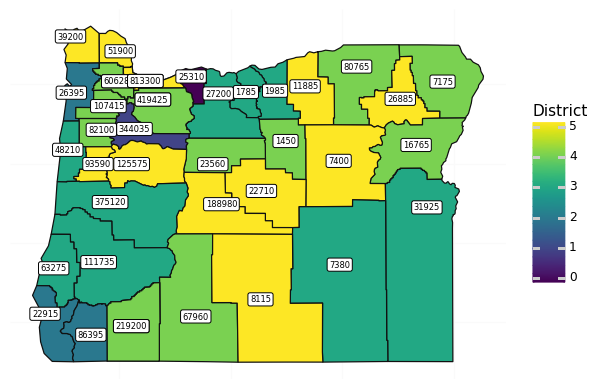

<ggplot: (8776790363326)>

In [13]:
map_results = (
ggplot(my_map3)
+ geom_map(aes(fill='District'))
+ geom_label(aes(x = 'Longitude', y = 'Latitude', label='Population2018', size = 2), show_legend=False)
+ theme_minimal()
+ theme(axis_text_x=element_blank(),
        axis_text_y=element_blank(),
        axis_title_x=element_blank(),
        axis_title_y=element_blank(),
        axis_ticks=element_blank(),
        panel_grid_major = element_blank()
       )
)
print('\033[1m'+'The results satisfy the current constraints, but we would like to see more compact districts that contain only one cluster per district.')
map_results

In [14]:
# Adding new constraints can eliminate multiple clusters in a district by eliminate that combination of counties.
# constraints with similar effects are sometimes generated as cut constraints in Operations Research is a separate problem to solve
# e.g. In the results Multnomah county is in the same district as Union county.
#      Create a constraint that does not allow Multnomah county and Union county to be in the same district 
#          without at least having the counties in between them in the same district.
#      For this model, those two counties are far enough away that a short cut is to just not
#          allow those two counties to be in the same district.

In [15]:
# future work : constraint to improve compactibility through minimizing the distance of counties within a district
# nonlinear model with pyomo or linear transformation 